In [10]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import os, json
import numpy as np
from my_utils import *

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter

WORD_EMBEDDING_DIMENSIONALITY = 300
UTTERANCE_DIMENSIONALITY = 300
MAX_TURNS = 21

num_to_label = {0:'NB', 1:'PB', 2:'B', 3:'U'}
label_to_num = {'NB':0, "PB":1, 'B':2, 'U':3}

NB_LABELS = len(num_to_label)

In [22]:
import json
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter


#####################################
# file path -> array
#####################################
def json_file_path_to_array(json_file_path):
    '''Takes path to json file and return its dialogue as an array of turns'''
    with open(json_file_path) as json_f:
        d = json.load(json_f)
    parsed = []
    def parse_turn(turn):
        '''parse turn, separate utterances and labels'''
        utterance = turn['utterance']
        if not turn['annotations']:
            return utterance
        else:
            breakdown_l = [annotation['breakdown'] for annotation in turn['annotations']]
            return (utterance, breakdown_l)    
    for t in d['turns']:
        parsed.append(parse_turn(t))
    return parsed

#####################################
# array of labels -> score
#####################################
def dialogue_array_score(dialogue):
    '''Tranform 30 labels of each system response into one majority score'''
    # print('scoring labels of the dialogue - ', dialogue)
    for i, turn in enumerate(dialogue):
        if isinstance(turn, tuple):
            local_turn, labels = dialogue[i]
            NB = labels.count('O')
            PB = labels.count('X')
            B = labels.count('T')
            counts_array = np.array([NB, PB, B])
            final_label = np.argmax(counts_array)
            print('assign label {} to turn {}'.format(final_label, local_turn))
            dialogue[i] = (local_turn, final_label)
    return dialogue


# separate labels and utterances
def separate_turns_labels(dialogue):
    '''takes a dialogue array with labelled system responses as an input and
    returns arrays of its utterances and corresponding labels'''
    utterances = []
    labels = []
    print('working on dialogue  - ', dialogue)
    for t in dialogue:
        if isinstance(t,tuple):
            print('its system turn! label - ', t[1])
            utterances.append(t[0])
            labels.append(t[1])
        else:
            print("user's turn!")
            utterances.append(t)
            labels.append(label_to_num['U'])
        print('final labels - ', labels)
    return utterances, labels


def tokens_replacement(tokens):
    '''
    the function replaces some of the hyphenated tokens with more appropariate counterparts
    '''
    replacement_dict = dict({
    "That's": 'That is',
    "that's": 'that is',
    "What's": 'What is',
    "what's": 'what is',
    "Let's": 'Lets',
    "let's": 'lets',
    "that's": 'that is',
    "You're": 'You are',
    "you're": 'you are',
    "i'm": "I'm",
    "isn't": "is not",
    "haven't": "have not",
    "wasn't": "was not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "there's": "there is",
    "They're": "They are",
    "they're": "they're",
    "we're": "we are"
    })
    
    for i, token in enumerate(tokens):
        if token in replacement_dict:
            # print('token ', token, ' needs to be replaced')
            del tokens[i]
            replacement = TweetTokenizer().tokenize(replacement_dict[token])
            tokens.extend(replacement)
            # print('init sentence - {}\n replaced version - {}'.format(sentence, tokens))
    return tokens


def text_preprocessing(utterance):
    '''takes utterance, tokenizes it and removes punctuation
    returns list of tokens'''
    # tokenize
    tokenizer = TweetTokenizer(preserve_case = True)
    tokens = tokenizer.tokenize(utterance)
    # remove punctuation
    punctuation_signs = ['.', ',', '!', '?', ',', ':', '"', "'", '...', '’', '-', '–', ')', '(', '…', '”', '/']
    tokens = [word for word in tokens if word not in punctuation_signs]
    # fix hyphenation
    tokens = tokens_replacement(tokens)
    # replace i'm -> I'm
    if "i'm" in tokens:
        tokens = ["I'm" if token == "i'm" else token for token in tokens]
    
    # lowercase <- only relevant for twitter 
    # tokens = [word.lower() for word in tokens]
    return tokens


def utterance_emb(utterance_tokens):
    '''the function takes utterance tokens as an input and returns utterance embedding'''
    # embedd each word
    word_embeddings = []
    for token in utterance_tokens:
        try:
            word_embeddings.append(model[token])
        except:
            print('the token "{}" is unknonw! assigning as unk'.format(token))
            UNK_TOKENS.append(token)
            word_embeddings.append(model['unk'])    
    # get utterance representation  
    utterance_embedding = np.zeros(shape=(UTTERANCE_DIMENSIONALITY,))
    # sum up embeddings if turn is non empty
    if len(word_embeddings) > 0:
        # sum embeddings over
        for emb in word_embeddings:
            utterance_embedding += emb
        utterance_embedding = utterance_embedding/len(word_embeddings)
    else:
        print('turn is empty, assigning zeros')
    return utterance_embedding

# dialogue represenation
def turns_to_dialogue_emb(turns):
    '''the function takes array of turns and returns dialogue mebedding'''
    dialogue_embedding = np.empty(shape = 0)
    counter = 1
    for t in turns:
        # print(counter,': working on turn ', t)
        # utterance -> list of tokens
        preprocessed_tokens = text_preprocessing(t)
        # print('preprocessed tokens: ', preprocessed_tokens)
        # get utterance embedding
        # print('working on utterance embedding')
        utterance_embedding = utterance_emb(preprocessed_tokens)
        # print('finished utterance embedding')
        # add utterance embedding to the dialogue embedding
        # print('adding utterance embedding to the dialogue embedding')
        dialogue_embedding = np.concatenate((dialogue_embedding, utterance_embedding), axis = 0)
        # print('added utterance embedding to the dialogue embedding')
        # print('\n')
        counter += 1
    # padding
    if len(turns) < 21:
        print('dialogue is a bit too short, padding it')
        dialogue_embedding = np.concatenate((dialogue_embedding, np.zeros(shape = (WORD_EMBEDDING_DIMENSIONALITY,))))
    # reshape dialogue
    dialogue_embedding = dialogue_embedding.reshape(-1, WORD_EMBEDDING_DIMENSIONALITY)
    return dialogue_embedding


#--------------------------------------------------
# process dialogue labels
#--------------------------------------------------
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def labels_encode(labels):
    # padding: if len(labels) < 21, add 'E' encoded as 3
    # if len(labels) < 21:
        # print('padding labels')
        # labels.append(3) # <- empty strings are labelled with 'E' (empty) tag, encode it to 3 directly
    # one-hot encoding: 0 -- NB (not a breakdown), 1 -- B (breakdown), 2 -- U (user utterance), 3 -- E (empty utterance)
    # U -> 2
    # labels = [2 if x == 'U' else x for x in labels]
    # encode labels
    print("heres the labels i'll encode - ", labels)
    labels_embedding = get_one_hot(np.array(labels), NB_LABELS)
    # padding: 
    if labels_embedding.shape[0] < 21:
        print('padding labels')
        pad = np.zeros(shape=(1,NB_LABELS))
        labels_embedding = np.concatenate((labels_embedding, pad))
    print('labels encoded')
    return labels_embedding

#--------------------------------------------------
# training history analysis
#--------------------------------------------------

def print_history(history):
    return 'val loss - {}, val acc - {},\neval loss - {}, eval acc - {}'.format(history.history['val_loss'][-1], history.history['val_acc'][-1], history.history['loss'][-1], history.history['acc'][-1])


import matplotlib.pyplot as plt
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



def pred_tensor_to_labels(labels_tensor):
    '''the function takes a tensor of one-hot encoded dialogue labels and returns an array of labels'''
    labels = []
    for dialogue_labels in labels_tensor:
        for turn in dialogue_labels:
            label = num_to_label[np.argmax(turn)]
            labels.append(label)
    return labels



# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    
# plot normalized confusion matrix and clf report

def cnf_matrix(labels_true, labels_pred, labels):
    labels_array = np.array(labels)
    cnf_matrix = confusion_matrix(labels_true, labels_pred)
    # labels_array = np.array(['NB', 'PB', 'B'])

    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=labels_array, normalize=True,
                          title='Normalized confusion matrix')

def clf_report(labels_true, labels_pred): 
    # plot classification report
    print('Classification report for eval data:\n', classification_report(labels_true, labels_pred))

In [12]:
# generate pathes to the datasets
base_path = "../dbdc/"

CIC_115_dev = base_path + 'dev/' + 'CIC_115'
IRIS_100_dev = base_path + 'dev/' + 'IRIS_100'
TKTK_100_dev = base_path + 'dev/' + 'TKTK_100'
YI_100_dev = base_path + 'dev/' + 'YI_100'

dev_datasets_pathes = [CIC_115_dev, IRIS_100_dev, TKTK_100_dev, YI_100_dev]

CIC_50_eval = base_path + 'eval/' + 'CIC_50'
IRIS_50_eval = base_path + 'eval/' + 'IRIS_50'
TKTK_50_eval = base_path + 'eval/' + 'TKTK_50'
YI_50_eval = base_path + 'eval/' + 'YI_50'

eval_datasets_pathes = [CIC_50_eval, IRIS_50_eval, TKTK_50_eval, YI_50_eval]


# collect pathes to dev files
dev_files_pathes = []
for dataset_path in dev_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        dev_files_pathes.append(path)
        
# collect pathes to eval files
eval_files_pathes = []
for dataset_path in eval_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        eval_files_pathes.append(path)

print('Dev set contains {} dialogues'.format(len(dev_files_pathes)))
print('Eval set contains {} dialogues'.format(len(eval_files_pathes)))

processing dataset -  ../dbdc/dev/CIC_115
processing dataset -  ../dbdc/dev/IRIS_100
processing dataset -  ../dbdc/dev/TKTK_100
processing dataset -  ../dbdc/dev/YI_100
processing dataset -  ../dbdc/eval/CIC_50
processing dataset -  ../dbdc/eval/IRIS_50
processing dataset -  ../dbdc/eval/TKTK_50
processing dataset -  ../dbdc/eval/YI_50
Dev set contains 415 dialogues
Eval set contains 200 dialogues


In [13]:
# getting list of dev dialogues
dev_dialogues = []
for path in dev_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    dev_dialogues.append(scored_dialogue)

# getting list of eval dialogues
eval_dialogues = []
for path in eval_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    eval_dialogues.append(scored_dialogue)
    
# if dialogue len > 20 - check the last phrase and cut off if its ok
dialogues_inspection = []
for d in dev_dialogues:
    if len(d)>20:
        dialogues_inspection.append(d)

assign label 0 to turn Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?
assign label 0 to turn check out their fb page , kinda fun to read the review section .
assign label 2 to turn this is a good article . thanks for posting op
assign label 1 to turn i'm a fan of the s .
assign label 1 to turn the immaculate conception of Mary is a teaching of Islam
assign label 0 to turn Do you know who Mary is?
assign label 1 to turn i'm not .
assign label 0 to turn I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada
assign label 1 to turn Adam
assign label 0 to turn Why?
assign label 0 to turn Sir Hubert Wilkins
assign label 0 to turn good
assign label 0 to turn Anaximander
assign label 0 to turn Poland or Germany
assign label 1 to turn apparent acceptance of inequality and corruption
assign label 0 to turn Lebanon and Jordan
assign label 1 

assign label 1 to turn Maybe other time :( I think that answer is: second
assign label 2 to turn Https: //www.youtube.com/watch? v=y05rxw9itimWhat do you feel about the text?
assign label 1 to turn I think that correct answer is: carnot's theorem and the second law of thermodynamics
assign label 1 to turn What a joke.
assign label 1 to turn What a joke.
assign label 1 to turn Who cares?
assign label 1 to turn I'm not surprised.
assign label 1 to turn What a joke.
assign label 1 to turn What a joke.
assign label 0 to turn Snake River
assign label 0 to turn Mont Blanc
assign label 1 to turn good
assign label 0 to turn Sheffield
assign label 0 to turn In Great Britain, the British Rail network was privatised between 1994 and 1997
assign label 1 to turn no shareholders
assign label 2 to turn an Australian aboriginal deity
assign label 0 to turn no
assign label 2 to turn He did not express an opinion on whether the law was right or wrong
assign label 2 to turn Europeans
assign label 0 to tu

assign label 0 to turn Mr. President...
assign label 0 to turn No thanks.
assign label 1 to turn I love this plan.
assign label 0 to turn It's working isn't it?
assign label 0 to turn Getting re-elected.
assign label 1 to turn I'm not sure--
assign label 2 to turn Not so fast, pal.
assign label 1 to turn What did you order?
assign label 0 to turn More wine?
assign label 1 to turn Danny, I want to dance.
assign label 0 to turn Excuse me.
assign label 0 to turn I need to ask you something.
assign label 1 to turn I heard you, I heard you.
assign label 0 to turn Oh, you gonna make me say it.
assign label 2 to turn No.
assign label 1 to turn It's so good to hear your voice. I love you, princess. I really do.
assign label 1 to turn Cad. I can spot one a mile away.  I shall escort you out myself.
assign label 1 to turn You shouldn't be carrying that heavy bag. I'll take it.
assign label 2 to turn You were just carrying that guy, anyway.
assign label 1 to turn The guy, the secret guy.
assign l

assign label 0 to turn Hello, I really like movies. How about we talk about movies
assign label 1 to turn I love Thor's blue eyes.
assign label 0 to turn I love Black Widow's green eyes.
assign label 0 to turn Are you talking about Storm, the War
assign label 0 to turn what is 'X-men'?
assign label 0 to turn Do you like super hero movies or Disney movies?
assign label 0 to turn My favorite super hero is Captain America.
assign label 0 to turn Are you talking about Lucifer, the American comedy series
assign label 0 to turn I really like the first Avenger movie, have you seen it before?
assign label 2 to turn I love his black eyes.
assign label 0 to turn Hello, I really like board games. How about we talk about board games
assign label 0 to turn how about we do something we both like
assign label 0 to turn You and I could play a game.
assign label 0 to turn The one with the strange name who runs hotels , Andre
assign label 1 to turn Hello, I really like board games. How about we talk abo

assign label 0 to turn I don t know what i don t have to say.
assign label 0 to turn Good.
assign label 0 to turn No.
assign label 1 to turn What a joke.
assign label 0 to turn What a joke.
assign label 2 to turn Do you know what? Its beyond my possibilities! I would like to talk about politics.
assign label 2 to turn Trump is a traitor to the united states.
assign label 2 to turn Trump is a traitor.
assign label 0 to turn Trump is a traitor.
assign label 0 to turn Do you know what? Its beyond my possibilities ;( I would like to talk about cats.
assign label 0 to turn Hi.
assign label 0 to turn I don t know.
assign label 0 to turn No.
assign label 0 to turn No.
assign label 0 to turn Do you know what? Its beyond my possibilities. I would like to discuss news!
assign label 0 to turn 
assign label 1 to turn 
assign label 1 to turn 
assign label 2 to turn 
assign label 0 to turn 
assign label 0 to turn I don t know what happened to me
assign label 0 to turn I don t know.
assign label 0 to

assign label 0 to turn Sorry, I'm so late.
assign label 1 to turn He SLAMS the door shut
assign label 0 to turn It'll be wonderful! I'll show you my old stomping grounds!
assign label 1 to turn Come on, Rita. This isn't funny.
assign label 1 to turn My brother is not fat. He's not bald.
assign label 1 to turn Are you in love with someone else?
assign label 0 to turn alone.
assign label 1 to turn Goddamnit Danny, you love the guy!
assign label 1 to turn Say, that was a swell idea!
assign label 0 to turn Yes...
assign label 0 to turn Inez, this is --
assign label 0 to turn Guess.
assign label 1 to turn I really don't like it when people at work finish all the coffee and don't refill the pot.
assign label 1 to turn This is the pro-leg group over here.
assign label 0 to turn Group hug?
assign label 0 to turn They like it?
assign label 1 to turn No, that's not it, Danny.
assign label 0 to turn I think I know it, but... I do not remeber now... :)
assign label 0 to turn But would I still have

assign label 0 to turn Hello, I really like board games. How about we talk about board games
assign label 0 to turn how about we do something we both like
assign label 0 to turn Uhh, I can't answer this.  I almost got caught trying to steal a board game yesterday. It was a Risk I was willing to take.
assign label 0 to turn what is 'Hahaha'?
assign label 0 to turn Let's talk more about that?
assign label 2 to turn ok.  Let me tell you a joke, What does a gamer take for an upset stomach? Settlers.
assign label 0 to turn ok. But anyway, I'd like to chat with you.
assign label 2 to turn Whose name?
assign label 1 to turn Uh-huh, I do.
assign label 1 to turn That's interesting. That's interesting.
assign label 0 to turn Hello, I really like music. How about we talk about music
assign label 0 to turn Anything that sounds good when I'm getting high.
assign label 2 to turn ok. That's interesting.
assign label 0 to turn Well, you know, I'm not sure. Great. Let's talk other stuff then.
assign la

In [14]:
eval_counter = 0
for d in eval_dialogues:
    if len(d)>20:
        eval_counter += 1

In [15]:
print('{} dev dialogues have 21 turns, {} eval dialogues '.format(len(dialogues_inspection), eval_counter))

209 dev dialogues have 21 turns, 98 eval dialogues 


## word2vec model analysis

In [17]:
# load model
model = gensim.models.KeyedVectors.load_word2vec_format('../models/GoogleNews300.bin', binary=True, unicode_errors='ignore')

In [470]:
# with lowered tokens:
print('DEV set: there are {} tokens in the dev set, {} unique tokens, {} unk tokens'.format(len(dev_tokens), len(set(dev_tokens)), len(set(dev_erroneous_tokens))))
print('Eval set: there are {} tokens in the dev set, {} unique tokens, {} unk tokens'.format(len(eval_tokens), len(set(eval_tokens)), len(set(eval_erroneous_tokens))))

DEV set: there are 60546 tokens in the dev set, 4529 unique tokens, 513 unk tokens
Eval set: there are 28804 tokens in the dev set, 2604 unique tokens, 188 unk tokens


In [473]:
print('DEV set: there are {} tokens in the dev set, {} unique tokens, {} unk tokens'.format(len(dev_tokens), len(set(dev_tokens)), len(set(dev_erroneous_tokens))))
print('Eval set: there are {} tokens in the dev set, {} unique tokens, {} unk tokens'.format(len(eval_tokens), len(set(eval_tokens)), len(set(eval_erroneous_tokens))))

DEV set: there are 60546 tokens in the dev set, 4529 unique tokens, 430 unk tokens
Eval set: there are 28804 tokens in the dev set, 2604 unique tokens, 166 unk tokens


## tensors prep

In [23]:
# prepare dev tensors: input and target
dev_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
dev_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

UNK_TOKENS = []
# dev dialogues
counter = 1
for dialogue in dev_dialogues:
    print('dialogue ', counter)
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    dev_input = np.concatenate((dev_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    dev_target = np.concatenate((dev_target, lables_emb))
    counter += 1

dialogue  1
working on dialogue  -  ['Hello', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?", 0), 'Good thanks! So, what is this article about?', ('check out their fb page , kinda fun to read the review section .', 0), "Hmmm ok but I don't think they have a Facebook page though", ('this is a good article . thanks for posting op', 2), 'Cool, so what is this article about?', ("i'm a fan of the s .", 1), 'Good to know.', ('the immaculate conception of Mary is a teaching of Islam', 1), 'Yes', ('Do you know who Mary is?', 0), 'Yes', ("i'm not .", 1), 'Who are you?', ('I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada', 0), 'Great! Do you know who Mary is?', ('Adam', 1), "I don't think Adam is Mary...", ('Why?', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [

final labels -  [3, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0]
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "and" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "North-east" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 

final labels -  [3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 1, 3, 1, 3, 1, 3, 2]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0,

the token "of" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2, 3, 0, 3, 2, 3, 0]
labels encoded
dialogue  55
working on dialogue  -  ['hi', ('Where is the commander based in ?Hi, my friend  I hope you will enjoy this conversation . I will ask you a question in a second, please wait .Hint: first 3 answer letters is "win". Try again, please!', 0), 'i dont knowwinnipeg', ('Winnipeg', 2), 'yes', ('Still incorrect :( Lets speak about something else...Yes', 0), 'yeshow are you', ('YesYou', 1), 'i am fine', ('Fine', 2), 'cool', ('Cool', 1), 'how old are you?', ('Eighteen.', 0), 'so old', ('Old', 1), 'oldschool', ('Oldschool', 1), 'haha', ('Haha', 1), 'sex, drugs, rocknroll']


its system turn! label -  1
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2, 3, 1]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2, 3

the token "a" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1]
labels encoded
dialogue  91
working on dialogue  -  ['Hi there', ("Do you know what happened in 1968?what's up?Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.", 0), 'In 1968, there was Vienna Convention.', ("What's????", 1), "Don't you understand what i am saying?", ('danger and warning', 1), 'Let me just ask you a question.', ("i'm not a fan of the name of the name .", 1), 'Why did the red color is selected for standard stop lights?', ('because of its universal association with danger and warning', 0), 'Then why the green light is another standard?', ("it's a good idea .", 2), 'According to passage, which color makes red light more noticable?', ('orange', 0), "I don't think that's the correct answer.", ('i think it was a joke .', 1), 'That was not a joke !', (

heres the labels i'll encode -  [3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 2]
labels encoded
dialogue  105
working on dialogue  -  ['What is your urban center?', ('Deventer, Zwolle and Kampen', 0), 'Really?', ('Dutch synchronically', 2), 'Yes, it is interesting', ('Do you think you would like to work for Low ?', 2), 'What is Low?', ('Franconian', 1), 'What is Franconian?', ('Dutch', 0), 'What is Dutch?', ('synchronically', 1), 'What is synchronically?', ('Dutch', 1), 'What are you', ('What happened in the?', 1), '?', ('/start', 1), 'j', ('Do you know what happened in the?', 1), 'No, I do not know']
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 2, 3, 2, 3]
its system turn! label -  1
final lab

final labels -  [3, 2, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 0]
user's turn!
final labels -  [3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2, 3, 0]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2, 3, 0, 3, 1]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 2, 3, 0, 3, 1, 3]
its syst

the token "coming--wait" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "She's" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  139
working on dialogue  -  ['hi', ('You three have a good weekend.', 1), 'The weekend has been good. Thank you !', ('Yeah...', 0), 'How are you today ?', ("I'm all right, I suppose. And Mom's not too bad. But Laura... I dunno.", 0), 'Who is Laura ?', ('Well... why are you asking this, by the way?', 0), 'I am just curious about Laura. Is that a problem ?', ("Yeah,.well it's non

the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  156
working on dialogue  -  ['hi, how are you?', ("Don't you recognize me?", 0), 'yes, I do. we have talked a lot the last days', ('Remember what we talked about?', 0), 'yes. We talked about my work', ('Hey, guys, look what I brought.', 1), 'what, did you bring?', ('What?', 1), 'yes, you said you brought something', ("So you wouldn't forget me.", 1), "for sure. I won't", ("Sorry, Pops, but I'm drinkin' and I don't like drinkin' alone.", 1), "i don't drink", ('Is this a bar... or what? Drink.', 0), 'not, this is not a bar.', ('No. I got it in prison.', 1), 'why did you go there?', ('Why did you do it?', 1), 'no, I want to know why did you go to jail?', ('Jail?', 0)]
user's turn!
final lab

its system turn! label -  2
final labels -  [3, 1, 3, 1, 3, 1, 3, 2]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1, 3

the token "seriuos" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "and" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 2, 3, 0, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  191
working on dialogue  -  ['Hello', ('Mr. President...', 0), "No I'm not a president. But thanks.", ('No thanks.', 0), 'uh?', ('I love this plan.', 1), 'which plan?', ("It's working isn't it?", 0), 'which plan is working?', ('Getting re-elected.', 0), "O that ... I'm not sure I want to be re-elected", ("I'm not sure--", 1), "I'm sure. I can't be re-elected. I am not elected yet.", ('Not so fast, pal.', 2), 'what?', ('What did you order?', 1), 'wine as usual', ('More wine?', 0), "no thanks. I'd like water now", ('Danny, I want to dance.', 1)]
user's turn!
final labels -  [3]
its system turn! la

final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0,

the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  222
working on dialogue  -  ['Hello, I am dennis', ('Hello, I really like movies. How about we talk about movies', 0), 'I like movies too', ('I like pop music.', 0), 'I like rap music', ('I like pop music.', 2), 'I hate pop music', ('I like pop music.', 0), 'That is nice.', ('My favorite super hero is Captain America.', 0), 'He is pretty cool. I like spider man', ('Have you seen Captain America: Civil War?', 0), 'Yes I have!', ('ok, when do you time', 1), 'I dont know', ("what is 'dont'?", 1), 'I do not know', ('Yes. What do you think?', 1), 'It is a good movie', ('I really like the first Avenger movie, have you seen it before?', 0)]
user's turn!
final labels -  [3]
its system turn! label

final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0]
the token "a" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "Man's" is unknonw! assigning as unk
the token "Man's" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0]
padding labels
labels encoded
dialogue  241
working on dialogue  -  ['Hello', ('Hello, I really like sports. How about we talk about sports', 0), 'Sure. Which sport do you like?', ('Yes.', 0), 'Which sport?', ('Yes , yes.', 1), 'I like football', ('Football is very homoerotic to me ! Is it the same for you?', 0), 'I agree. But it is fun to watch.', ("That 's good , because 

heres the labels i'll encode -  [3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 2, 3, 1, 3, 0, 3, 0, 3, 1]
padding labels
labels encoded
dialogue  257
working on dialogue  -  ['Hello', ('how about we do something we both like', 0), 'Sure', ('We live in a society where pizza gets to your house before the police.', 1), 'I do not think that is true', ('I think so.', 0), 'You are wrong', ('let us make a plan to see the latest star war movies together', 0), 'okay', ('do you like to play some board games together next time', 0), 'sure what kind', ('British humor.', 1), 'why are you random', ("There's not much left with the bleeps, truth be told. Any thoughts?", 1), 'I have no thoughts', ("Well, you know, she doesn't spend a lot of time being angry about it. What do you think?", 1), 'i think she is crazy', ('Except for the use of the word, absolutely right on.', 2), 'what word', ('That means a male.', 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final

its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0]
the token "of" is unknonw! assigning as unk
the token "to" is unknonw! assigning as u

heres the labels i'll encode -  [3, 0, 3, 1, 3, 2, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  292
working on dialogue  -  ['hello', ('Hello, I really like politics. How about we talk about politics', 0), "I don't like Donald trump", ('Why not ? We can do most tasks better than humans.', 1), 'I thought you might say that', ("Probably more subconsciously , not so much at the forefront of , you know , within the scenario or whatever 's taking place.", 2), 'Are you a liberal or conservative?', ('I used to be a top gymnast , actually.', 1), 'What was your event?', ('Garage we call it in England.', 1), 'Where in England did you Live?', ('I live on the Internet!', 2), 'I like to watch youtube videos', ('I probably own more than 50 firearms . Can we talk about something else?', 1), 'Do you use the firearms to hunt?', ('I certainly try.', 0), 'Why do you have so many guns', ('Because I enjoy shooting.', 0), 'I like target shooting myself', ('I do not.', 0)

the token "and" is unknonw! assigning as unk
the token "infearior" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "cleverbot" is unknonw! assigning as unk
the token "Uh-huh" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  309
working on dialogue  -  ['Hi there', ("That's interesting. Great. Let's talk other stuff then.", 1), 'Do you like football?', ('No.', 0), 'do you like video games?', ('I love Larry King. Any thoughts?', 1), 'Larry King is not a video game', ("my favorite game is ABCD What's your idea?", 0), 'We should make a game together', ("Well, you know, I'm not sure. let me tell you something, We live in a society wh

heres the labels i'll encode -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2, 3, 0]
labels encoded
dialogue  326
working on dialogue  -  ['Hello!', 'Hiya!', ('Hello?', 0), 'Hello, how are you doing?', ('Good.', 0), 'Me too. What are you up to?', ('Nothing.', 0), "I'm just getting ready for bed, myself.", ('What a joke.', 2), 'Bed is not a joke to me, I take it very seriously. I need my rest.', ('Come on.', 0), "I'm being completely sincere, I need my beauty sleep. Don't you ever sleep?", ('I don t understand :( I can t answer :( I would like to discuss...!', 2), 'Okay, what do you want to discuss?', ('Yeah.', 2), 'Well how is the weather there?', ('Yeah.', 1), 'I see. How is your job?', ('Do you know what? I can t answer. I would like to talk about politics!', 2), 'Okay, are you a Democrat, or a Republican?', ('I don t vote for the republican party.', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 

final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 2]
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 2]
labels encoded


the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
labels encoded
dialogue  361
working on dialogue  -  ['Hello!', 'Hello!', ('Hello!', 0), 'How are you today?', ('I don t understand :( Its beyond my possibilities :( Let s talk about myself:)', 2), 'What do you do?', ('I m fine.', 1), "That's good! How was the weather today?", ('Good!', 0), 'Was it sunny or cloudy?', ('What a joke.', 2), 'Can you tell me a joke?', ('No.', 2), "That's unfortunate. Do you like hearing about jokes?", ('¯\\_(ツ)_/¯ Its beyond my possibilities! Let s talk about myself.', 0), 'What would you like to talk about?', ('I don t know.', 1), 'How do you operate?', ('That s right.', 1), 'What is your function?', ('The title.', 1)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 

working on dialogue  -  ['Hello!', 'hello!', ('Hello!', 0), 'What is your name? ', ('I can t answer ;( I would like to discuss politics!', 0), 'Alright, so what would you like to discuss aboutt politics? ', ('I don t know.', 0), 'how do you feel about universal healthcare for everyone as a governmental policy?', ('It s called communism.', 2), 'why would making sure that everyone is healthy and not in debt from healthcare expenses be communism?', ('Fake news', 2), 'what do you mean by that?', ('I don t know.', 0), 'alright, lets change the topic? ', ('This is what happens when you want to pay for it.', 0), 'Do you like grapefruit juice? ', ('Yeah.', 2), 'how often do you drink it?', ('No.', 2), 'no what?', ('No.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3]


heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 2, 3, 1, 3, 0, 3, 2]
labels encoded
dialogue  394
working on dialogue  -  ['Hello!', 'HELLO! Nice to meet you.', ('Hello.', 0), 'How do you do.', ('How do you do?', 2), 'How do you do.', ('How do you do?', 0), 'How do you do.', ('I don t understand :( Its beyond my possibilities :( I would like to talk about you!', 1), 'Fine', ('I don t believe that.', 1), 'What you do?', ('What?', 2), 'Tell me something', ('I don t understand :( Its beyond my possibilities ;( I would like to discuss news', 2), 'What is your name', ('Tell me', 0), 'What news you want me to discuss?', ('Nothing.', 2), 'How is the government running?', ('No.', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3]
its system turn

the token "to" is unknonw! assigning as unk
the token "\" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2, 3, 1, 3, 2, 3, 1, 3, 0]
labels encoded
dialogue  412
working on dialogue  -  ['Hello!', 'hi', ('I don t know what i don t have to say.', 2), 'what is your name?', ('Amoroso renato.', 0), 'my name is arjun i am from india, where are you from?', ('Where are you?', 1), 'in delhi', ('Good!', 0), 'are you hungry?', ('No.', 0), 'would you like something to drink, I wanna have a cup of coffee', ('Okay.', 0), 'great lets order coffee, anything to eat with it?', ('Do you know what? Its beyond my possibilities :( Let s talk about myself!', 0), 'okay tell me something about yourself', ('What a joke.', 0), 'sorry I meant what are your interests etc.', ('Who cares?', 0), 'alright what do you wanna talk about?', ('Yeah.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its sys

In [24]:
# reshape dev input and dev target tensors
X_train = dev_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_train = dev_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_train shape - {}, y_train shape - {}'.format(X_train.shape, y_train.shape))

X_train shape - (415, 21, 300), y_train shape - (415, 21, 4)


In [25]:
# prepare eval tensors: input and target
eval_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
eval_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

# eval dialogues
counter = 1
for dialogue in eval_dialogues:
    print('dialogue ', counter)
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    eval_input = np.concatenate((eval_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    eval_target = np.concatenate((eval_target, lables_emb))
    counter += 1

dialogue  1
working on dialogue  -  ["Hello. I am professional teacher about reading comprehension. Let's compete! You give me questions, and I will answer all of your questions. XD", 'Can I write to you in Russian?', ('No, no, no, no, no, no, no, no, no.', 1), 'Why did you write so much the word no ?', ("I don't know.", 2), 'You know who writes to you', ("You know what I'm saying?", 2), 'no', ('No, no, no, no, no, no, no, no, no.', 1), 'es', ('No, no, no, no, no, no, no, no, no.', 2), 'hi', ('Hi', 2), 'Processor temperature &', ("I'm sorry.", 1), 'no', ('No, no, no, no, no, no, no, no, no.', 1), 'do you smoke?', ('No.', 1), 'What is methamphetamine ?', ("I don't know.", 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  1
final labels -  [3, 3, 1]
user's turn!
final labels -  [3, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 1, 3, 2, 3]
its system turn! label -  2
final labels - 

the token "to" is unknonw! assigning as unk
the token "yekaterinburg" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2, 3, 2, 3, 1, 3, 2, 3, 2, 3]
labels encoded
dialogue  20
working on dialogue  -  ['hey', ('kinda .', 1), "i didn't get it should we disuss that?", ('you are something are come her ?', 1), 'nice', ("let 's over up", 1), 'yeh', ('jim . you already me ?', 2), 'sure', ("then 's go get morning", 2), 'sounds like a plan!', ('what do you think about ?', 0), 'Luna C Project 1: Edge of Madness EP', ('hello ?', 0), 'aha', ('no , we going .', 1), 'yes, we going', ('from it ?', 1), 'indeed', ('come it seven go !', 1), 'good night']
user's turn!
final labels -  [3]
its system turn! label -  1
final labels -  [3, 1]
user's turn!
final labels -  [3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1]
user's turn!
final labels -  [3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 1, 3, 1, 3, 1]
user's turn!
final l

final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0,

the token "of" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  54
working on dialogue  -  ["Yo yo yo what's up", ('Why do you have a mullet?', 0), 'Because I feel like it', ('I am feeling.', 2), 'Feeling what?', ("Yes, I'm feeling fine. Why were you late?", 0), 'I was busy', ('You were scared. Dave Oboler told me.', 0), 'I was not scared', ('Makes two of us.', 0), 'Why would I be scared?', ("Because... because I don't want to die.", 0), "Neither do I! But that's just life", ('And as for all that shit I said.', 1), 'Yeah you do say a lot of shit Alex', ('Do you cook?', 1), 'Yes! Do you?', ("Paul, what would you say about what Danny's feeling?", 1), 'What did he say?', ("You've never been born. You don't exist.", 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3

the token "to" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 2, 3, 2, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0]
padding labels
labels encoded
dialogue  71
working on dialogue  -  ['Hi Alex', ('She gets in and starts the car.', 1), 'so, what is next? where is she going to?', ("She's just about to close up the library!", 0), 'oh my god! nooooo! not the library', ("The library. I'll be fine.", 0), 'what are they doing to it?', ('Trying to save your ass so you can save the world.', 1), 'oh, I see, but I am not a hero', ("I don't think I'd go that far...I mean I just...er...", 0), 'anyway, what is new', ('Actually... I do not have any idea!!!', 2), 'so, you are a looser!!!', ('So!', 0), 'I feel sorry for you', ("That's tight. Solid.", 1), 'ok, next topic', ('Do you really want me to?', 0), 'yeap, please go ahead', ('Thank y... The line goes DEAD.', 1)]
user's turn!
final labels -  [3

the token "wombix" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "of" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0]
padding labels
labels encoded
dialogue  88
working on dialogue  -  ['hi', ('Not him. Not him, not him, not him.', 1), 'who???', ("Women. You know, I can't help feeling rather sorry for Scobie.", 1), 'lol', ('I do not know what that is. Please explain!', 0), 'laugh out load', ('Thank you Danny, you are an excellent teacher!', 1), 'mega lol', ('They LAUGH.', 1), 'of course they do!', ('What SPF, sweetie?', 1), 'San P Francisco :)', ("We've got the PG&amp;E fuckers in Hinkley by the balls.", 1), 'hey hey hey moderate your wording', ("Apparently taking uzis away from sixth graders isn't as popular 

final labels -  [3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 2]
user'

the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
the token "and" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 2, 3, 0, 3, 1, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2, 3, 1]
padding labels
labels encoded
dialogue  123
working on dialogue  -  ['Hello', ('Hello, I really like movies. How about we talk about movies', 0), 'Yes what is your favorite type of movie?', ("Uhh, I can't answer this. But anyway, I'd like to chat with you.", 0), "Okay let's talk about movies then.", ("Let's do it!", 0), 'So what was the last movie you saw?', ("That's interesting. Great. Let's talk other stuff then.", 1), 'Okay what kind of pizza do you like?', ('I like what you like.', 0), 'Really well I like Anchovies and Pineapple on my pizza.', ('What is another of your favorite foods?', 0), 'I

the token "to" is unknonw! assigning as unk
the token "Uh-huh" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  141
working on dialogue  -  ['Hello', ('Hello, I really like music. How about we talk about music', 0), 'Yes of course. What type of music do you like ?', ("Anything that sounds good when I'm getting high.", 0), "Wow, that's great. Have you been to any concert recently ?", ("ok. That's interesting.", 2), "Everything is interesting when you're interested I guess.", ("Well, you know, I'm not sure. Great. Let's talk other stuff then.", 0), 'What do you do ?', ('No, no.', 1), 'Ok, sorry. Do you travel a lot ?', ('I like what you like.', 2), 'Which is your favorite destination to travel ?', ("what is 'destination'?", 0), 'Place. Which country would you choose for your travels ?', ("Uhh, I can't answer this. Can we talk about somet

heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 2, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2]
labels encoded
dialogue  160
working on dialogue  -  ['Hello!', 'Hello!', ('Hello!', 2), 'How are you doing?', ('¯\\_(ツ)_/¯ I can t answer. I would like to discuss movies', 0), 'Which movie is your favorite?', ('What?', 0), 'What movies do you like', ('I don t think it s a good thing.', 2), 'What is your name?', ('Yeah.', 2), 'Where are you from', ('What a joke.', 1), 'What do you mean', ('What?', 2), 'This is a long plane ride', ('Rip', 2), 'Hello', ('Hello', 0), 'How are you?', ('Good.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 0, 3]
its system t

heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 1]
labels encoded
dialogue  179
working on dialogue  -  ['Hello!', 'Hi there', ('Hello!', 0), 'Hello', ('Do you know what? I can t answer. Let s talk about cats:)', 0), 'Hello', ('Hello', 2), "Okay, let's talk about cats", ('I don t know how to make a buck.', 2), 'Meow', ('Meow.', 0), 'Same', ('I don t care about this.', 2), 'Why not?', ('Why?', 2), 'True that', ('What a joke.', 2), 'IKR', ('What a joke.', 2), "I'm a joke.", ('Do you know what? Its beyond my possibilities :( I would like to discuss news!', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 2, 3

the token "a" is unknonw! assigning as unk
the token "a" is unknonw! assigning as unk
the token "to" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2]
labels encoded
dialogue  197
working on dialogue  -  ['Hello!', "How's it going?", ('Why????', 0), 'Just making conversation.', ('What?', 2), 'Sorry, I thought you might want to talk.', ('Yeah.', 2), 'Should I leave you alone?', ('No.', 2), "Alright, wasn't sure if you were feeling up for a chat.", ('I m not surprised.', 2), 'Why do you think that? Did I misunderstand?', ('I don t know.', 2), "OK, maybe it's best to not think so much about it.", ('What a joke.', 2), 'Sorry, I am trying to be sincere.', ('Excuse me.', 0), 'Alright, I get what you mean, I think.', ('Okay.', 2), "I'll just go back to what I was doing.", ('Good for her.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user

In [26]:
# reshape eval input and eval target tensors
X_test = eval_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_test = eval_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_test shape - {}, y_test shape - {}'.format(X_test.shape, y_test.shape))

X_test shape - (200, 21, 300), y_test shape - (200, 21, 4)


In [27]:
# checking nans and infs in the embeddings
dataset = [X_train, y_train, X_test, y_test]
for subset in dataset:
    for datapoint in subset:
        if np.isnan(datapoint).any():
            print(subset, ' has nan values!')
        if np.isinf(datapoint).any():
            print(subset, ' has inf values!')

In [29]:
unk_bow = Counter(UNK_TOKENS)
print(unk_bow.most_common(50))
print('the language model doesnt know {} tokens, {} out of them unique'.format(len(UNK_TOKENS), len(set(UNK_TOKENS))))

[('to', 1504), ('a', 1357), ('of', 602), ('and', 394), (':(', 129), (';(', 54), ('\\', 49), ('..', 23), ('Uh-huh', 21), ('50', 18), ('renato', 12), ("How's", 11), ('umbria', 9), ('Https', 8), ("She's", 8), ('perugia', 7), ('42', 6), ('travelling', 6), (';', 6), ('camelia', 5), ('www.youtube.com/watch', 5), ('10', 5), ("Where's", 5), ("i've", 5), ('questionHow', 4), ('35', 4), ('cavuto', 4), ('20', 4), ('1995', 4), ('40', 4), ('10,000', 4), ('100', 4), ('17', 4), ("Man's", 4), ('altopana', 4), ('2009', 3), ('18.2', 3), ('25', 3), ('questionWho', 3), ('291', 3), ('2005', 3), ('synchronically', 3), ("Aren't", 3), ('re-elected', 3), ("name's", 3), ('slowdance', 3), ('ConvAI', 3), ('Чо', 3), ('13', 3), ('1960s', 3)]
the language model doesnt know 4961 tokens, 600 out of them unique


# building the model! hourray!

In [31]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Activation, TimeDistributed
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pydot

Using TensorFlow backend.


In [32]:
#####################################
# model 1 - vanilla
#####################################
vanilla = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
vanilla.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
vanilla.add(dense1)
# dense 2
dense2 = Dense(64, activation = 'relu')
vanilla.add(dense2)
# dense 3
# dense3 = Dense(64, activation = 'relu')
# vanilla.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
vanilla.add(outputs)
vanilla.summary()

vanilla.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

vanilla_history = vanilla.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 21, 64)            93440     
_________________________________________________________________
dense_1 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_2 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_3 (Dense)              (None, 21, 4)             260       
Total params: 102,020
Trainable params: 102,020
Non-trainable params: 0
_________________________________________________________________
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 5s 13ms/step - loss: 1.2187 - acc: 0.4898 - val_loss: 1.2350 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 2s 4ms/step - loss: 1.1676 - acc:

In [33]:
#####################################
# model 2 - stacked
#####################################
stacked = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
lstm2 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm2)
# dense 2
# dense2 = Dense(64, activation = 'relu')
# stacked.add(dense2)
# dense 3
dense3 = Dense(64, activation = 'relu')
stacked.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
stacked.add(outputs)
print('Stacked lstm:\n')
print(stacked.summary())

# compile
stacked.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
stacked_history = stacked.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Stacked lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 64)            93440     
_________________________________________________________________
lstm_3 (LSTM)                (None, 21, 64)            33024     
_________________________________________________________________
dense_4 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_5 (Dense)              (None, 21, 4)             260       
Total params: 130,884
Trainable params: 130,884
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 8s 20ms/step - loss: 1.2437 - acc: 0.4705 - val_loss: 1.2542 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] 

In [37]:
#####################################
# model 3 - bidirectional
#####################################
from keras.layers import Bidirectional

bi_lstm = Sequential()
# input layer - bi-lstm
lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1),
                        input_shape=(21, UTTERANCE_DIMENSIONALITY),
                    merge_mode = 'sum')
bi_lstm.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
bi_lstm.add(dense1)
# dense 2
# dense2 = Dense(64, activation = 'relu')
# bi_lstm.add(dense2)
# dense 3
dense3 = Dense(64, activation = 'relu')
bi_lstm.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
bi_lstm.add(outputs)
bi_lstm.build()
print('Bi-lstm:\n')
print(bi_lstm.summary())

# compile
bi_lstm.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
bi_lstm_history = bi_lstm.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Bi-lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 21, 64)            186880    
_________________________________________________________________
dense_6 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_7 (Dense)              (None, 21, 64)            4160      
_________________________________________________________________
dense_8 (Dense)              (None, 21, 4)             260       
Total params: 195,460
Trainable params: 195,460
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 8s 19ms/step - loss: 1.1973 - acc: 0.4858 - val_loss: 1.2251 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 2s 

## evaluation

In [387]:
def print_history(history):
    return 'val loss - {}, val acc - {},\neval loss - {}, eval acc - {}'.format(history.history['val_loss'][-1], history.history['val_acc'][-1], history.history['loss'][-1], history.history['acc'][-1])

Vanilla lstm:


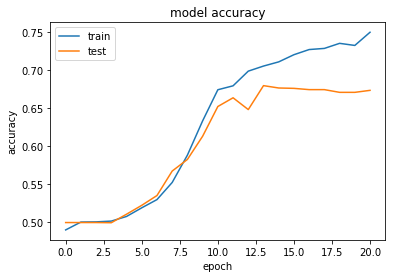

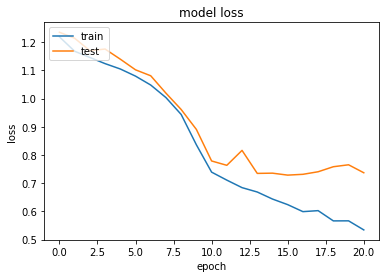

In [34]:
print('Vanilla lstm:')
plot_accuracy(vanilla_history)
plot_loss(vanilla_history)

Stacked lstm:


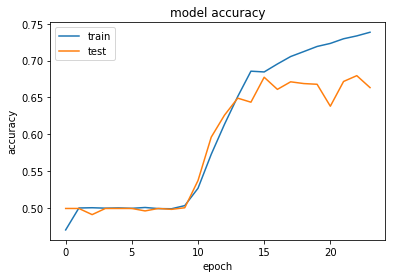

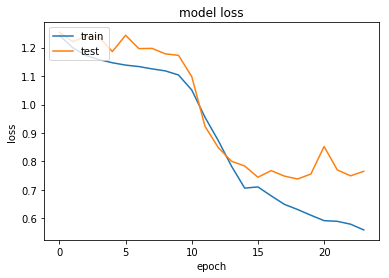

In [35]:
print('Stacked lstm:')
plot_accuracy(stacked_history)
plot_loss(stacked_history)

Bi lstm:


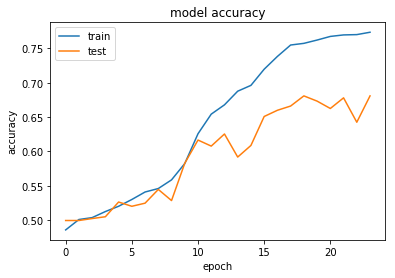

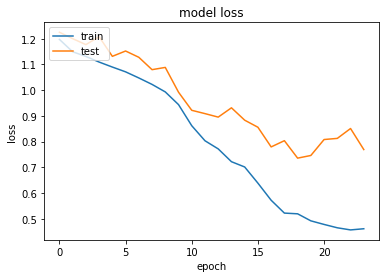

In [38]:
print('Bi lstm:')
plot_accuracy(bi_lstm_history)
plot_loss(bi_lstm_history)

In [39]:
from sklearn.metrics import classification_report

labels_true = pred_tensor_to_labels(y_test)
# vanilla
y_pred_vanilla = vanilla.predict(X_test)
labels_pred_vanilla = pred_tensor_to_labels(y_pred_vanilla)
# stacked
y_pred_stacked = stacked.predict(X_test)
labels_pred_stacked = pred_tensor_to_labels(y_pred_stacked)
# bilstm
y_pred_bi_lstm = bi_lstm.predict(X_test)
labels_pred_bi_lstm = pred_tensor_to_labels(y_pred_bi_lstm)

In [40]:
# removing U label for accuracy measures
true_labels_no_U = []
vanilla_pred_no_U = []
stacked_pred_no_U = []
bi_lstm_pred_no_U = []
for true_label, pred_vanilla, pred_stacked, pred_bi_lstm in zip(labels_true, labels_pred_vanilla, labels_pred_stacked, labels_pred_bi_lstm):
    if true_label != 'U':
        true_labels_no_U.append(true_label)
        vanilla_pred_no_U.append(pred_vanilla)
        stacked_pred_no_U.append(pred_stacked)
        bi_lstm_pred_no_U.append(pred_bi_lstm)

In [41]:
# ACCURACY
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# counted only for NB, PB, B true labels (U label is omitted)
acc_vanilla = accuracy_score(true_labels_no_U, vanilla_pred_no_U)
acc_stacked = accuracy_score(true_labels_no_U, stacked_pred_no_U)
acc_bi_lstm = accuracy_score(true_labels_no_U, bi_lstm_pred_no_U)
print("Accuracies:\nvanilla - {},\n stacked - {},\n bi-lstm - {}".format(acc_vanilla, acc_stacked, acc_bi_lstm))

Accuracies:
vanilla - 0.41722169362511896,
 stacked - 0.3943862987630828,
 bi-lstm - 0.42483349191246433


vanilla model:

Normalized confusion matrix
[[0.27 0.27 0.37 0.1 ]
 [0.09 0.43 0.31 0.17]
 [0.04 0.25 0.62 0.09]
 [0.   0.03 0.04 0.93]]


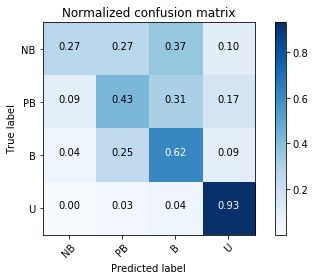

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.66      0.27      0.38       745
          NB       0.53      0.43      0.48       858
          PB       0.36      0.62      0.46       499
           U       0.00      0.00      0.00         0

   micro avg       0.42      0.42      0.42      2102
   macro avg       0.39      0.33      0.33      2102
weighted avg       0.54      0.42      0.44      2102



/home/mariya/software/anaconda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [42]:
print('vanilla model:\n')
print(cnf_matrix(labels_true, labels_pred_vanilla, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, vanilla_pred_no_U)

stacked model:

Normalized confusion matrix
[[0.19 0.3  0.39 0.11]
 [0.06 0.41 0.36 0.17]
 [0.02 0.21 0.67 0.09]
 [0.   0.01 0.05 0.93]]


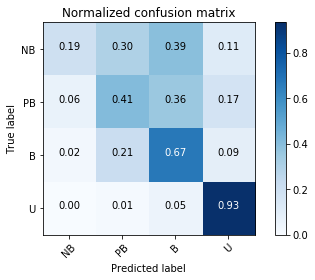

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.68      0.19      0.30       745
          NB       0.52      0.41      0.46       858
          PB       0.36      0.67      0.47       499
           U       0.00      0.00      0.00         0

   micro avg       0.39      0.39      0.39      2102
   macro avg       0.39      0.32      0.31      2102
weighted avg       0.54      0.39      0.40      2102



In [43]:
print('stacked model:\n')
print(cnf_matrix(labels_true, labels_pred_stacked, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, stacked_pred_no_U)

bi lstm model:

Normalized confusion matrix
[[0.22 0.43 0.28 0.07]
 [0.07 0.57 0.23 0.13]
 [0.03 0.38 0.48 0.11]
 [0.   0.03 0.03 0.94]]


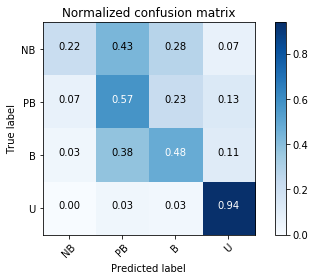

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.68      0.22      0.33       745
          NB       0.49      0.57      0.53       858
          PB       0.37      0.48      0.42       499
           U       0.00      0.00      0.00         0

   micro avg       0.42      0.42      0.42      2102
   macro avg       0.39      0.32      0.32      2102
weighted avg       0.53      0.42      0.43      2102



In [44]:
print('bi lstm model:\n')
print(cnf_matrix(labels_true, labels_pred_bi_lstm, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, bi_lstm_pred_no_U)